# Import & Paths

In [ ]:
from google.colab import userdata

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import json
import os
import cv2

from IPython.core.magic import register_cell_magic
@register_cell_magic
def skip(line, cell):
    print(line)
    return

In [ ]:
project_path = userdata.get('PATH_PROJECT')
dataset_path = os.path.join(project_path, 'dataset')
metadata_path = os.path.join(dataset_path, 'dataset_metadata.json')
psnr_table_path = os.path.join(dataset_path, 'psnr_table.csv')


# Preload

## Check if we can pre-load all images

You can check the available memory in your Colab runtime using the `%shell` magic command and system commands.

In [ ]:
%shell free -h

               total        used        free      shared  buff/cache   available
Mem:            12Gi       975Mi       8.8Gi       1.0Mi       3.0Gi        11Gi
Swap:             0B          0B          0B


In [ ]:
# CPUs
%shell nproc

2


In [ ]:
%%skip There is enough memory

image_dirs = ['clean', 'new', 'ref']
total_size_bytes = 0

for image_dir in image_dirs:
    dir_path = os.path.join(dataset_path, image_dir)
    if os.path.exists(dir_path):
        for filename in os.listdir(dir_path):
            if filename.endswith('.png'): # Assuming your images are PNG files
                file_path = os.path.join(dir_path, filename)
                total_size_bytes += os.path.getsize(file_path)

# Convert bytes to a more readable format (e.g., MB, GB)
total_size_mb = total_size_bytes / (1024 ** 2)
total_size_gb = total_size_bytes / (1024 ** 3)

print(f"Total size of image files: {total_size_bytes} bytes")
print(f"Total size of image files: {total_size_mb:.2f} MB")
print(f"Total size of image files: {total_size_gb:.2f} GB")

There is enough memory


## Pre-load all images

You can now use the 'loaded_images_dict' dictionary. For example:
```
if '4547604' in loaded_images_dict:
    display(loaded_images_dict['4547604'])
```

### List all images as tuples: `all_image_files = [(path, id), ...]`

In [ ]:
# %%skip Comment out skip to load all the images

from tqdm import tqdm
from cv2 import imread, IMREAD_COLOR_RGB

# Pre-load images into dictionaries
print("Pre-loading images...")
image_dirs = [os.path.join(dataset_path, image_dir) for image_dir in ['clean', 'new', 'ref']]
loaded_images_dict = dict()

for dir_path in image_dirs:
    if os.path.exists(dir_path):
        print(f"Loading dir: {str.split(dir_path, '/')[-1]}")
        for filename in tqdm(os.listdir(dir_path), desc="Loading images"):
            file_id = int(os.path.splitext(filename)[0])
            file_path = os.path.join(dir_path, filename)
            img = imread(file_path, IMREAD_COLOR_RGB)
            if img is not None:
                loaded_images_dict[file_id] = img

        print() # After sameline print in loop

print(f"Finished pre-loading {len(loaded_images_dict)} images.")

Pre-loading images...
Loading dir: clean


Loading images: 100%|██████████| 1849/1849 [00:21<00:00, 86.62it/s] 



Loading dir: new


Loading images: 100%|██████████| 1849/1849 [00:21<00:00, 84.86it/s] 



Loading dir: ref


Loading images: 100%|██████████| 1849/1849 [00:23<00:00, 78.95it/s] 


Finished pre-loading 5547 images.


# Visualizations: PSNR vs Pair Score

## Calculate PSNR per Image Pair

In [ ]:
%%skip Comment out skip to calculate and save PSNR table

def calculate_psnr(img1, img2):
    """Calculates the Peak Signal-to-Noise Ratio (PSNR) between two images."""
    # Ensure images are of the same size and type
    # Convert images to float32 for accurate calculations
    img1 = img1.astype(np.float32)
    img2 = img2.astype(np.float32)

    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return float('inf')
    max_pixel = 255.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

# Create a list of dictionaries to store the data for the table
psnr_table_data = []

# Iterate through metadata to get image pairs and calculate PSNR
# Assuming 'images' dictionary is already populated with loaded images
meta = pd.read_json(metadata_path)

print("Generating PSNR table...")
for index, row in meta.iterrows():
    clean_id = str(row['clean_image'])
    distorted_id = str(row['distorted_image'])
    method = row['metadata']['method']

    img_clean = images.get(clean_id)
    img_distorted = images.get(distorted_id)

    if img_clean is not None and img_distorted is not None:
        psnr_val = calculate_psnr(img_clean, img_distorted)
        psnr_table_data.append({
            'clean_image': clean_id,
            'distorted_image': distorted_id,
            'method': method,
            'psnr': psnr_val
        })

print("Finished generating PSNR table.")

# Convert the list of dictionaries into a pandas DataFrame
psnr_table_df = pd.DataFrame(psnr_table_data)

# Define the path to save the PSNR table CSV
psnr_table_path = os.path.join(dataset_path, 'psnr_table.csv')

# Save the DataFrame to a CSV file
psnr_table_df.to_csv(psnr_table_path, index=False)

print(f"PSNR table saved to {psnr_table_path}")


# Display the DataFrame
display(psnr_table_df)

Generating PSNR table...
Finished generating PSNR table.
PSNR table saved to /content/drive/MyDrive/Colab Notebooks/Samsung/dataset/psnr_table.csv


,clean_image,distorted_image,method,psnr
0,4547604,4547601,new,28.426134
1,4547604,4547602,ref,35.604702
2,4547612,4547609,new,33.684372
3,4547612,4547610,ref,38.338356
4,4547644,4547641,new,32.582279
...,...,...,...,...
3693,4656722,4656720,ref,36.325245
3694,4656766,4656763,new,38.017212
3695,4656766,4656764,ref,39.463993
3696,4656822,4656819,new,34.693600


from matplotlib import pyplot as plt
psnr_table_df['psnr'].plot(kind='hist', bins=20, title='psnr')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
psnr_table_df.groupby('method').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
psnr_table_df['psnr'].plot(kind='line', figsize=(8, 4), title='psnr')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(psnr_table_df['method'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(psnr_table_df, x='psnr', y='method', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

## PSNR Histogram

Calculating PSNR...
Finished calculating PSNR.


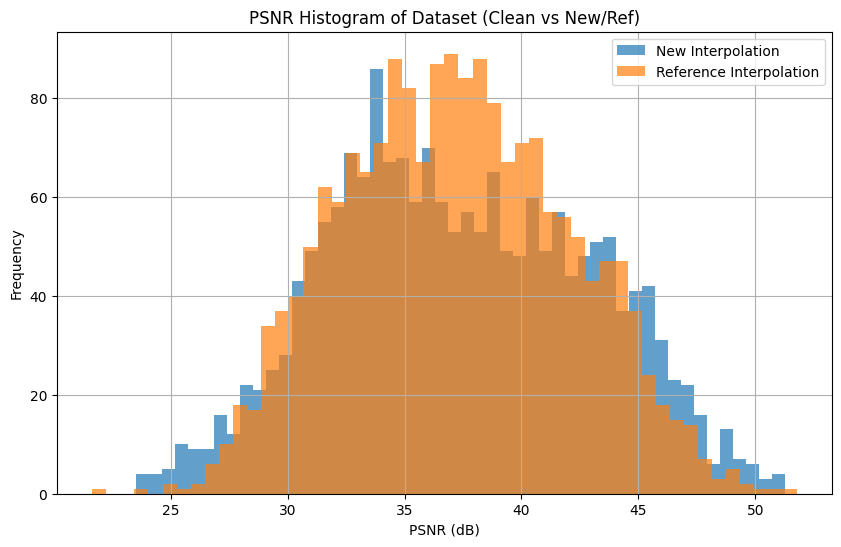

In [ ]:

# List to store PSNR values
psnr_values_new = []
psnr_values_ref = []

# Iterate through metadata to find image pairs and calculate PSNR using pre-loaded images
with open(psnr_table_path) as f:
    psnr_df = pd.read_csv(f)

print("Extracting  PSNR...")
for index, row in psnr_df.iterrows():
    method = row['method']
    psnr_val = row['psnr']

    match method:
        case 'new': psnr_values_new.append(psnr_val)
        case 'ref': psnr_values_ref.append(psnr_val)

print("Finished Extracting PSNR.")

# Plotting the histograms
plt.figure(figsize=(10, 6))
plt.hist(psnr_values_new, bins=50, alpha=0.7, label='New Interpolation')
plt.hist(psnr_values_ref, bins=50, alpha=0.7, label='Reference Interpolation')
plt.xlabel('PSNR (dB)')
plt.ylabel('Frequency')
plt.title('PSNR Histogram of Dataset (Clean vs New/Ref)')
plt.legend()
plt.grid(True)
plt.show()

## Violin Plot

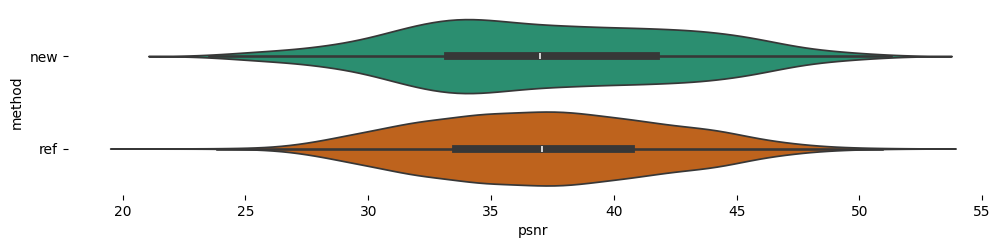

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(psnr_table_df['method'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(psnr_table_df, x='psnr', y='method', inner='box', palette='Dark2', hue='method')
sns.despine(top=True, right=True, bottom=True, left=True)

## Scatter Plot

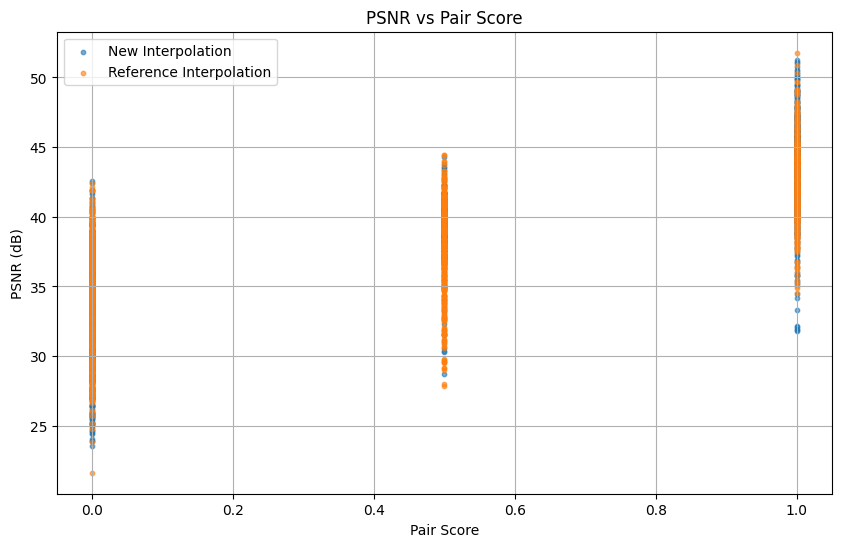

In [ ]:
# Combine PSNR values with pair scores
# Assuming meta DataFrame contains the 'score' column and 'clean_image', 'distorted_image' to match with PSNR calculations

# Load the PSNR table from the saved CSV file
psnr_table_path = os.path.join(dataset_path, 'psnr_table.csv')
psnr_table_df = pd.read_csv(psnr_table_path)

# Merge the PSNR table with the metadata to get scores
# We need to merge based on 'clean_image' and 'distorted_image'
merged_df = pd.merge(psnr_table_df, meta, left_on=['clean_image', 'distorted_image'], right_on=['clean_image', 'distorted_image'])

# Create a DataFrame for scatter plot data
# Select relevant columns and rename for clarity
scatter_df = merged_df[['psnr', 'score', 'method']]

# Create the scatter plot
plt.figure(figsize=(10, 6))

# Separate data by method for different colors/markers
scatter_new = scatter_df[scatter_df['method'] == 'new']
scatter_ref = scatter_df[scatter_df['method'] == 'ref']

plt.scatter(scatter_new['score'], scatter_new['psnr'], alpha=0.6, label='New Interpolation', s=10) # s is marker size
plt.scatter(scatter_ref['score'], scatter_ref['psnr'], alpha=0.6, label='Reference Interpolation', s=10)

plt.xlabel('Pair Score')
plt.ylabel('PSNR (dB)')
plt.title('PSNR vs Pair Score')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Optional: Calculate correlation coefficient
correlation_new = scatter_new['score'].corr(scatter_new['psnr'])
correlation_ref = scatter_ref['score'].corr(scatter_ref['psnr'])

print(f"Correlation between PSNR and Pair Score (New Interpolation): {correlation_new:.2f}")
print(f"Correlation between PSNR and Pair Score (Reference Interpolation): {correlation_ref:.2f}")

Correlation between PSNR and Pair Score (New Interpolation): 0.81
Correlation between PSNR and Pair Score (Reference Interpolation): 0.76


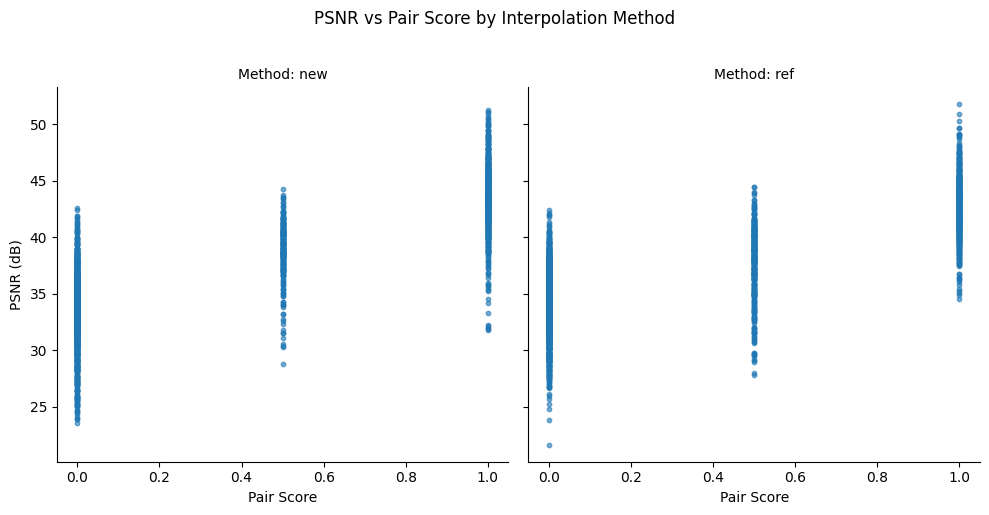

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a FacetGrid to plot PSNR vs Score for each method
g = sns.FacetGrid(scatter_df, col="method", height=5, aspect=1)
g.map(plt.scatter, "score", "psnr", alpha=0.6, s=10)

# Add titles and labels
g.set_axis_labels("Pair Score", "PSNR (dB)")
g.set_titles("Method: {col_name}")
plt.suptitle('PSNR vs Pair Score by Interpolation Method', y=1.02) # Add a main title
plt.tight_layout() # Adjust layout to prevent overlapping titles
plt.show()

## Box Plots

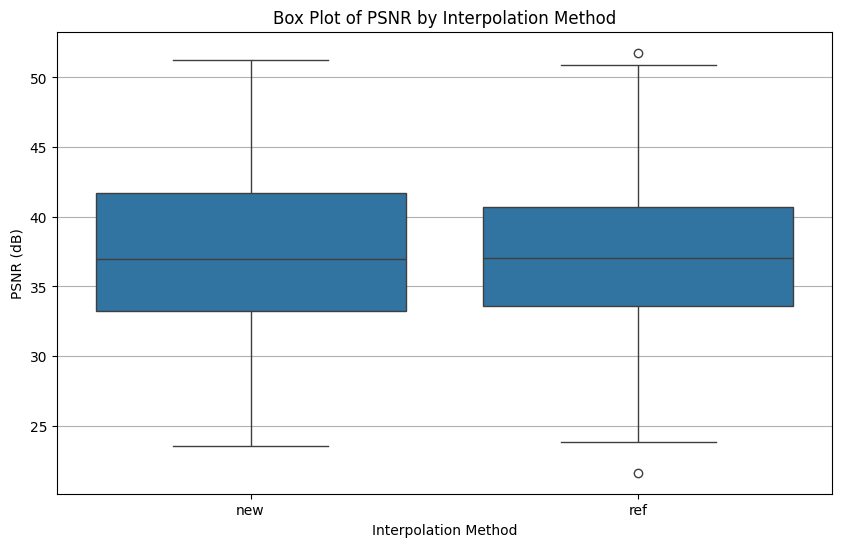

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.boxplot(data=scatter_df, x='method', y='psnr')
plt.xlabel('Interpolation Method')
plt.ylabel('PSNR (dB)')
plt.title('Box Plot of PSNR by Interpolation Method')
plt.grid(axis='y')
plt.show()

# Test Where the Diff Region is

In [ ]:
from PIL import ImageChops, Image
from collections import defaultdict

image_pair_diffs = defaultdict()
meta = pd.read_json(metadata_path)

meta['method'] = meta['unique_sample_id'].apply(lambda id: id[:3])

def getdiff(clean_id, other_id):
    clean = Image.fromarray(loaded_images_dict[clean_id])
    other = Image.fromarray(loaded_images_dict[other_id])

    return ImageChops.difference(clean, other)

In [ ]:
meta

,unique_sample_id,clean_image,distorted_image,score,metadata,method
0,new_Fuziki_case10_2789_2650,4547604,4547601,0.0,"{'crop_id': 4547601, 'image_source': 'Fuziki',...",new
1,ref_Fuziki_case10_2789_2650,4547604,4547602,0.5,"{'crop_id': 4547602, 'image_source': 'Fuziki',...",ref
2,new_Fuziki_case10_1057_1620,4547612,4547609,0.0,"{'crop_id': 4547609, 'image_source': 'Fuziki',...",new
3,ref_Fuziki_case10_1057_1620,4547612,4547610,0.5,"{'crop_id': 4547610, 'image_source': 'Fuziki',...",ref
4,new_Fuziki_case10_2515_4412,4547644,4547641,0.0,"{'crop_id': 4547641, 'image_source': 'Fuziki',...",new
...,...,...,...,...,...,...
3693,ref_RES40_case8_3349_2648,4656722,4656720,0.0,"{'crop_id': 4656720, 'image_source': 'RES40', ...",ref
3694,new_RES40_case8_3881_2647,4656766,4656763,0.0,"{'crop_id': 4656763, 'image_source': 'RES40', ...",new
3695,ref_RES40_case8_3881_2647,4656766,4656764,0.5,"{'crop_id': 4656764, 'image_source': 'RES40', ...",ref
3696,new_RES40_case8_1699_5984,4656822,4656819,0.0,"{'crop_id': 4656819, 'image_source': 'RES40', ...",new


In [ ]:
for _, clean_id, other_id, method in meta[['clean_image', 'distorted_image', 'method']].itertuples():
    diff = getdiff(clean_id, other_id)
    image_pair_diffs[other_id] = (method, diff)


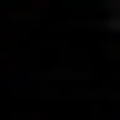

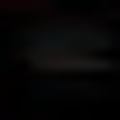

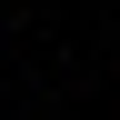

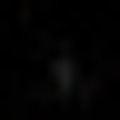

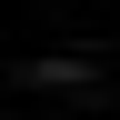

KeyboardInterrupt: 

In [ ]:
from itertools import islice
from IPython.display import clear_output
from time import sleep

for i in range(0, len(image_pair_diffs), 5):
    for id, (method, diff) in islice(image_pair_diffs.items(), i, i + 5):
        display(diff.crop((4,4,16,16)).resize((120,120)))

    sleep(1)
    clear_output(True)

## Thresholding

In [ ]:
from PIL import Image

def thresh_rgb(img, thresh):
    # Split the image into individual channels (R, G, B)
    r_channel, g_channel, b_channel = diff.split()

    # Apply thresholding to each channel
    # For each pixel, if the value is greater than the threshold, set it to 255 (white), otherwise set it to 0 (black)
    thresholded_r = r_channel.point(lambda p: p if p > thresh else 0)
    thresholded_g = g_channel.point(lambda p: p if p > thresh else 0)
    thresholded_b = b_channel.point(lambda p: p if p > thresh else 0)

    # Merge the thresholded channels back into a single image
    thresholded_image = Image.merge('RGB', (thresholded_r, thresholded_g, thresholded_b))

    return thresholded_image

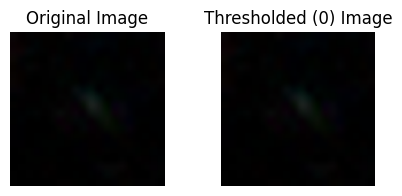

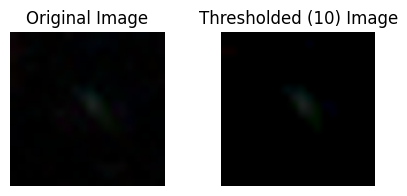

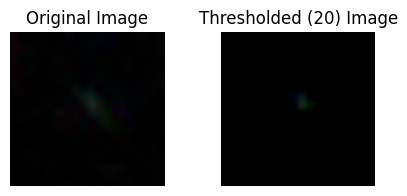

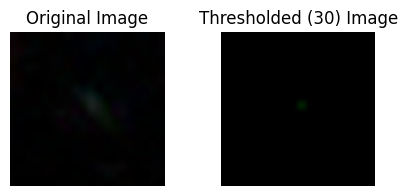

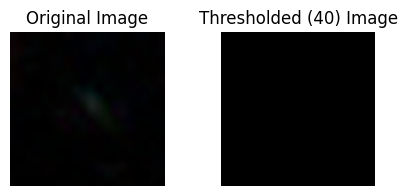

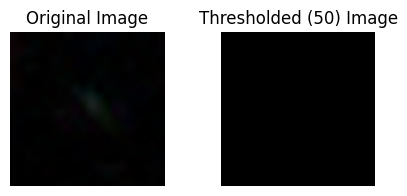

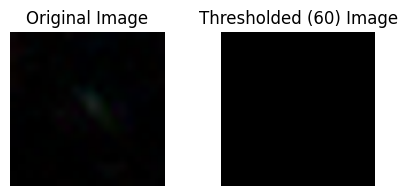

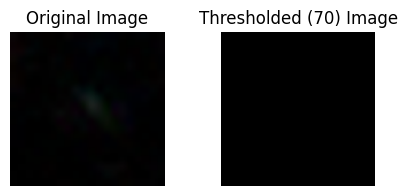

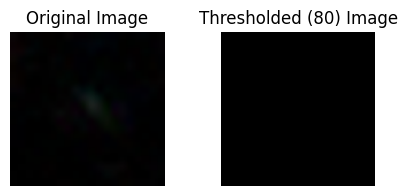

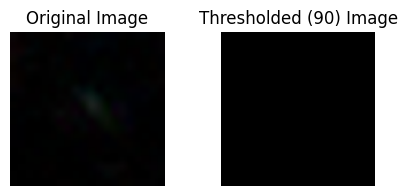

In [ ]:
import matplotlib.pyplot as plt

for thresh in range(0, 91, 10):
    thresholded_image = thresh_rgb(diff, thresh)
    # Display the original and thresholded images
    fig, axes = plt.subplots(1, 2, figsize=(5, 2)) # Create figure and axes together

    axes[0].imshow(diff.resize((120,120)))
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    axes[1].imshow(thresholded_image.resize((120,120)))
    axes[1].set_title(f"Thresholded ({thresh}) Image")
    axes[1].axis('off')

    plt.show() # Call plt.show() after setting up both subplots